In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, zero_one_loss, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from imblearn.under_sampling import NearMiss
from collections import Counter

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, zero_one_loss, log_loss, roc_auc_score

from matplotlib import pyplot
from imblearn.under_sampling import NearMiss
from collections import Counter

import sys
import pandas as pd
import time
import random
from scipy.stats import uniform, truncnorm, randint
from imblearn.under_sampling import NearMiss


import numpy as np
from numpy import loadtxt
from numpy.random import seed

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# function to reset all RNG's to seed 23
def reset_random_seeds():
   tf.random.set_seed(23) # tensorflow's seed
   np.random.seed(23) # numpy's seed
   random.seed(23) # python's seed

# import data
data = pd.read_csv (r'bank-additional\bank-additional.csv', sep = ';', engine= 'python')
#data = data.head(1000)
length = data.shape[0]
data.head()

# select variables
cats_to_use = ['age', 'default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed', 'y']
data = data[cats_to_use]

# 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
#       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
#       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
#       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'

# save lists of categorical and numerical variables
cat_cols = ['default', 'contact', 'month', 'poutcome', 'y']
num_cols = ['age', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']

# create column transformer to 1 one-hot-encode cat vars and 2 noralise num vars
ct = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_cols), # drop first column (reference)
    (StandardScaler(), num_cols),
)

# transform base table (pandas df -> numpy array)
base = ct.fit_transform(data)

# convert base table to p.df for ease of use (numpy array -> pandas df)
base_temp = pd.DataFrame(base, columns=ct.get_feature_names_out().tolist())
base_temp

# seperate base table into X and y and convert to numpy array (base pandas df -> y numpy array + X numpy array)
y = base_temp['onehotencoder__y_yes'].values
X = base_temp.drop(columns=['onehotencoder__y_yes']).values

# save and check dimensions of X 
(X_length, X_vars) = X.shape
X_length, X_vars

# reset RNG's
reset_random_seeds()

# undersample data to get 50/50 success ratio using near-miss-1
undersample = NearMiss(version=1)
X, y = undersample.fit_resample(X, y)

(X_length, X_vars) = X.shape
X_length, X_vars

(902, 19)

In [3]:
# create train/test split
train_features, test_features, train_targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=23)

In [4]:
ss = StandardScaler()
X = ss.fit_transform(train_features)
X_test_ss = ss.transform(test_features)

# niet genormaliseerd
# X_train_ss = train_features
# X_test_ss = test_features
print(X.shape)

(721, 19)


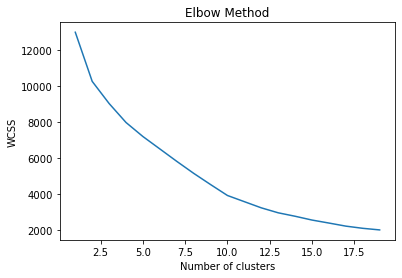

In [5]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X) # Compute cluster centers and predict cluster index for each sample

print(pred_y)

[3 2 3 3 2 0 3 2 5 8 2 2 2 3 3 0 7 1 1 2 2 4 3 2 1 2 2 7 4 4 4 4 2 3 3 2 8
 0 0 2 1 4 4 2 2 4 1 0 8 0 2 3 0 7 2 7 1 0 1 3 3 3 1 2 3 4 0 2 3 1 1 8 2 3
 3 3 4 0 6 3 0 2 4 1 4 0 2 0 2 3 0 2 7 1 2 4 1 2 7 9 3 3 4 2 4 3 4 2 8 2 0
 3 3 4 3 2 0 2 3 7 8 0 3 6 7 4 1 2 3 2 1 4 0 3 0 3 2 2 3 9 0 1 0 3 1 3 2 2
 1 0 1 0 2 0 8 2 1 7 3 2 0 2 4 3 1 4 2 8 3 4 3 2 3 2 4 0 2 3 3 1 0 3 3 7 4
 3 3 2 4 1 1 4 2 1 1 3 0 3 6 5 3 2 0 0 4 3 1 0 4 3 0 3 1 0 4 2 3 7 1 0 9 0
 4 4 3 2 3 8 0 0 2 3 3 0 3 4 8 2 7 3 3 0 0 3 0 1 4 4 1 1 0 4 8 9 5 3 8 2 0
 2 0 2 3 0 0 2 1 8 4 9 3 1 3 3 7 4 1 1 0 2 0 3 0 0 2 0 2 2 2 3 3 3 4 2 4 0
 4 3 8 6 3 4 9 0 0 0 6 3 3 3 7 2 0 2 7 1 5 4 4 1 2 4 4 3 4 2 2 4 3 2 0 3 0
 3 4 1 4 2 4 0 7 0 4 3 8 1 4 3 5 3 1 6 0 2 3 2 5 3 4 1 2 4 1 4 7 7 4 2 0 0
 3 1 2 4 3 0 7 2 0 7 0 2 0 5 3 2 3 2 3 0 4 3 1 2 7 0 2 2 0 0 7 3 2 3 0 4 0
 3 3 3 7 3 3 0 0 4 3 2 2 3 2 2 0 4 3 3 1 5 3 4 4 2 4 7 0 4 9 5 2 4 3 0 4 4
 4 5 3 0 4 5 3 3 2 2 3 2 2 1 4 8 3 4 2 2 2 0 3 9 2 4 2 3 0 4 2 1 2 1 0 3 4
 0 2 2 3 1 1 5 4 4 4 1 2 

In [7]:
Counter(pred_y)

Counter({3: 175,
         2: 138,
         0: 120,
         5: 20,
         8: 24,
         7: 41,
         1: 73,
         4: 102,
         6: 9,
         9: 19})

In [9]:
df = pd.DataFrame(pred_y, columns = ['Clusters'])
print(df)

     Clusters
0           3
1           2
2           3
3           3
4           2
..        ...
716         0
717         1
718         3
719         1
720         3

[721 rows x 1 columns]
